# Event Display — Paper Figure Recreation

Recreates the event display figure from the OneBQF paper using the `lhcb_velo_toy` package.
Shows a 5-layer detector with two primary vertices and particle tracks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import pairwise
import os

from lhcb_velo_toy import PlaneGeometry, StateEventGenerator

## 1. Detector Setup & Event Generation

In [2]:
# Detector geometry: 5 layers, 33 mm spacing, 33x33 mm modules
dz = 33
n_particles = [3, 3]
events = len(n_particles)
layers = 5

module_id = list(range(1, layers + 1))
lx = [33] * layers
ly = [33] * layers
zs = [dz * l for l in range(1, layers + 1)]

Detector = PlaneGeometry(module_id=module_id, lx=lx, ly=ly, z=zs)

# Event generator: zero noise for clean event display
state_event_gen = StateEventGenerator(
    Detector,
    events=events,
    n_particles=n_particles,
    measurement_error=0.0,
    collision_noise=0.0,
)

# Two separate primary vertices
state_event_gen.set_primary_vertices([(0, 0, 100), (0, 0, -50)])

# Generate particles
event_particles = []
for event_idx in range(events):
    particles_list = [{'type': 'MIP', 'mass': 0.511, 'q': 1}
                      for _ in range(n_particles[event_idx])]
    event_particles.append(particles_list)

state_event_gen.generate_particles(event_particles)
event_tracks = state_event_gen.generate_complete_events()

print(f"Generated {events} events")
print(f"Total tracks: {event_tracks.n_tracks}")
print(f"Total hits: {event_tracks.n_hits}")

Generated 2 events
Total tracks: 6
Total hits: 28


## 2. Paper-Style Event Display

In [3]:
def plot_event_paper_style(event, detector, figsize=(10, 6), dpi=300,
                           filename="paper_event_display", save_to_file=True,
                           label_si_pos=None, label_sj_pos=None, show_pv=False):
    """
    Publication-quality event display matching the OneBQF paper figure style.
    
    Shows detector layers as vertical bars, true track segments in color,
    false segments in gray, and hit markers.
    """
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif']
    plt.rcParams['font.size'] = 11
    plt.rcParams['axes.linewidth'] = 1.2
    
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    # Get layer positions
    layer_positions = sorted(set(detector.z))
    
    # Group hits by layer
    hits_by_layer = {z: [] for z in layer_positions}
    for hit in event.hits:
        hits_by_layer[hit.z].append(hit)
    
    # Y range for plot limits
    all_y_values = [hit.y for hit in event.hits]
    y_min, y_max = min(all_y_values), max(all_y_values)
    y_range = max(y_max - y_min, 1.0)
    y_margin = 0.15 * y_range
    
    # Draw detector layers
    for z_pos in layer_positions:
        ax.axvline(x=z_pos, color='black', linewidth=4, zorder=1, alpha=0.8)
    
    # Color palette sorted by track y-position (top to bottom)
    track_ids = sorted(set(hit.track_id for hit in event.hits))
    track_y_avg = {}
    for tid in track_ids:
        track_hits = [hit for hit in event.hits if hit.track_id == tid]
        track_y_avg[tid] = np.mean([hit.y for hit in track_hits])
    sorted_tracks = sorted(track_ids, key=lambda tid: track_y_avg[tid], reverse=True)
    
    color_palette = [
        '#F39C12', '#E67E22', '#E74C3C', '#9B59B6',
        '#2ECC71', '#1ABC9C', '#3498DB', '#16A085',
    ]
    track_id_to_color = {tid: color_palette[i % len(color_palette)]
                         for i, tid in enumerate(sorted_tracks)}
    
    # Draw false segments (cross-track) first
    for i in range(len(layer_positions) - 1):
        z1, z2 = layer_positions[i], layer_positions[i + 1]
        for hit1 in hits_by_layer[z1]:
            for hit2 in hits_by_layer[z2]:
                if hit1.track_id != hit2.track_id:
                    ax.plot([hit1.z, hit2.z], [hit1.y, hit2.y],
                           color='black', linewidth=1.0, alpha=0.5, zorder=1)
    
    # Draw true segments (same track) on top
    for i in range(len(layer_positions) - 1):
        z1, z2 = layer_positions[i], layer_positions[i + 1]
        for hit1 in hits_by_layer[z1]:
            for hit2 in hits_by_layer[z2]:
                if hit1.track_id == hit2.track_id:
                    color = track_id_to_color.get(hit1.track_id, '#95A5A6')
                    ax.plot([hit1.z, hit2.z], [hit1.y, hit2.y],
                           color=color, linewidth=3.0, alpha=0.95, zorder=3)
    
    # Draw primary vertices and dashed lines to first layer
    if show_pv and event.primary_vertices:
        first_layer_z = min(layer_positions)
        for pv in event.primary_vertices:
            ax.scatter(pv.z, pv.y, s=200, c='black', marker='*',
                      zorder=10, edgecolors='black', linewidths=1.5)
            for hit in hits_by_layer[first_layer_z]:
                color = track_id_to_color.get(hit.track_id, '#95A5A6')
                ax.plot([pv.z, hit.z], [pv.y, hit.y],
                       color=color, linewidth=4.0, alpha=0.95,
                       linestyle='--', zorder=2)
    
    # Draw hit markers
    for hit in event.hits:
        ax.scatter(hit.z, hit.y, s=90, c='black', zorder=4, edgecolors='none')
        ax.scatter(hit.z, hit.y, s=35, c='white', zorder=5, edgecolors='none')
    
    # Axis limits and labels
    ax.set_xlim(min(layer_positions) - 5, max(layer_positions) + 5)
    ax.set_ylim(y_min - y_margin, y_max + y_margin)
    
    if label_si_pos is not None:
        ax.text(*label_si_pos, '$S_i = 1$', fontsize=18,
               fontweight='bold', ha='center', va='center', rotation=-18)
    if label_sj_pos is not None:
        ax.text(*label_sj_pos, '$S_j = 0$', fontsize=18,
               fontweight='bold', ha='center', va='center')
    
    # Clean up axes
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_facecolor('none')
    fig.patch.set_alpha(0.0)
    plt.tight_layout()
    
    if save_to_file:
        os.makedirs('Plots', exist_ok=True)
        plt.savefig(f'Plots/{filename}.pdf', bbox_inches='tight',
                   transparent=False, facecolor='white', dpi=dpi)
        plt.savefig(f'Plots/{filename}.jpeg', bbox_inches='tight',
                   transparent=False, facecolor='white', dpi=dpi)
        print(f"Saved to Plots/{filename}.pdf and .jpeg")
    
    plt.show()
    plt.rcParams.update(plt.rcParamsDefault)

Saved to Plots/paper_event_display.pdf and .jpeg


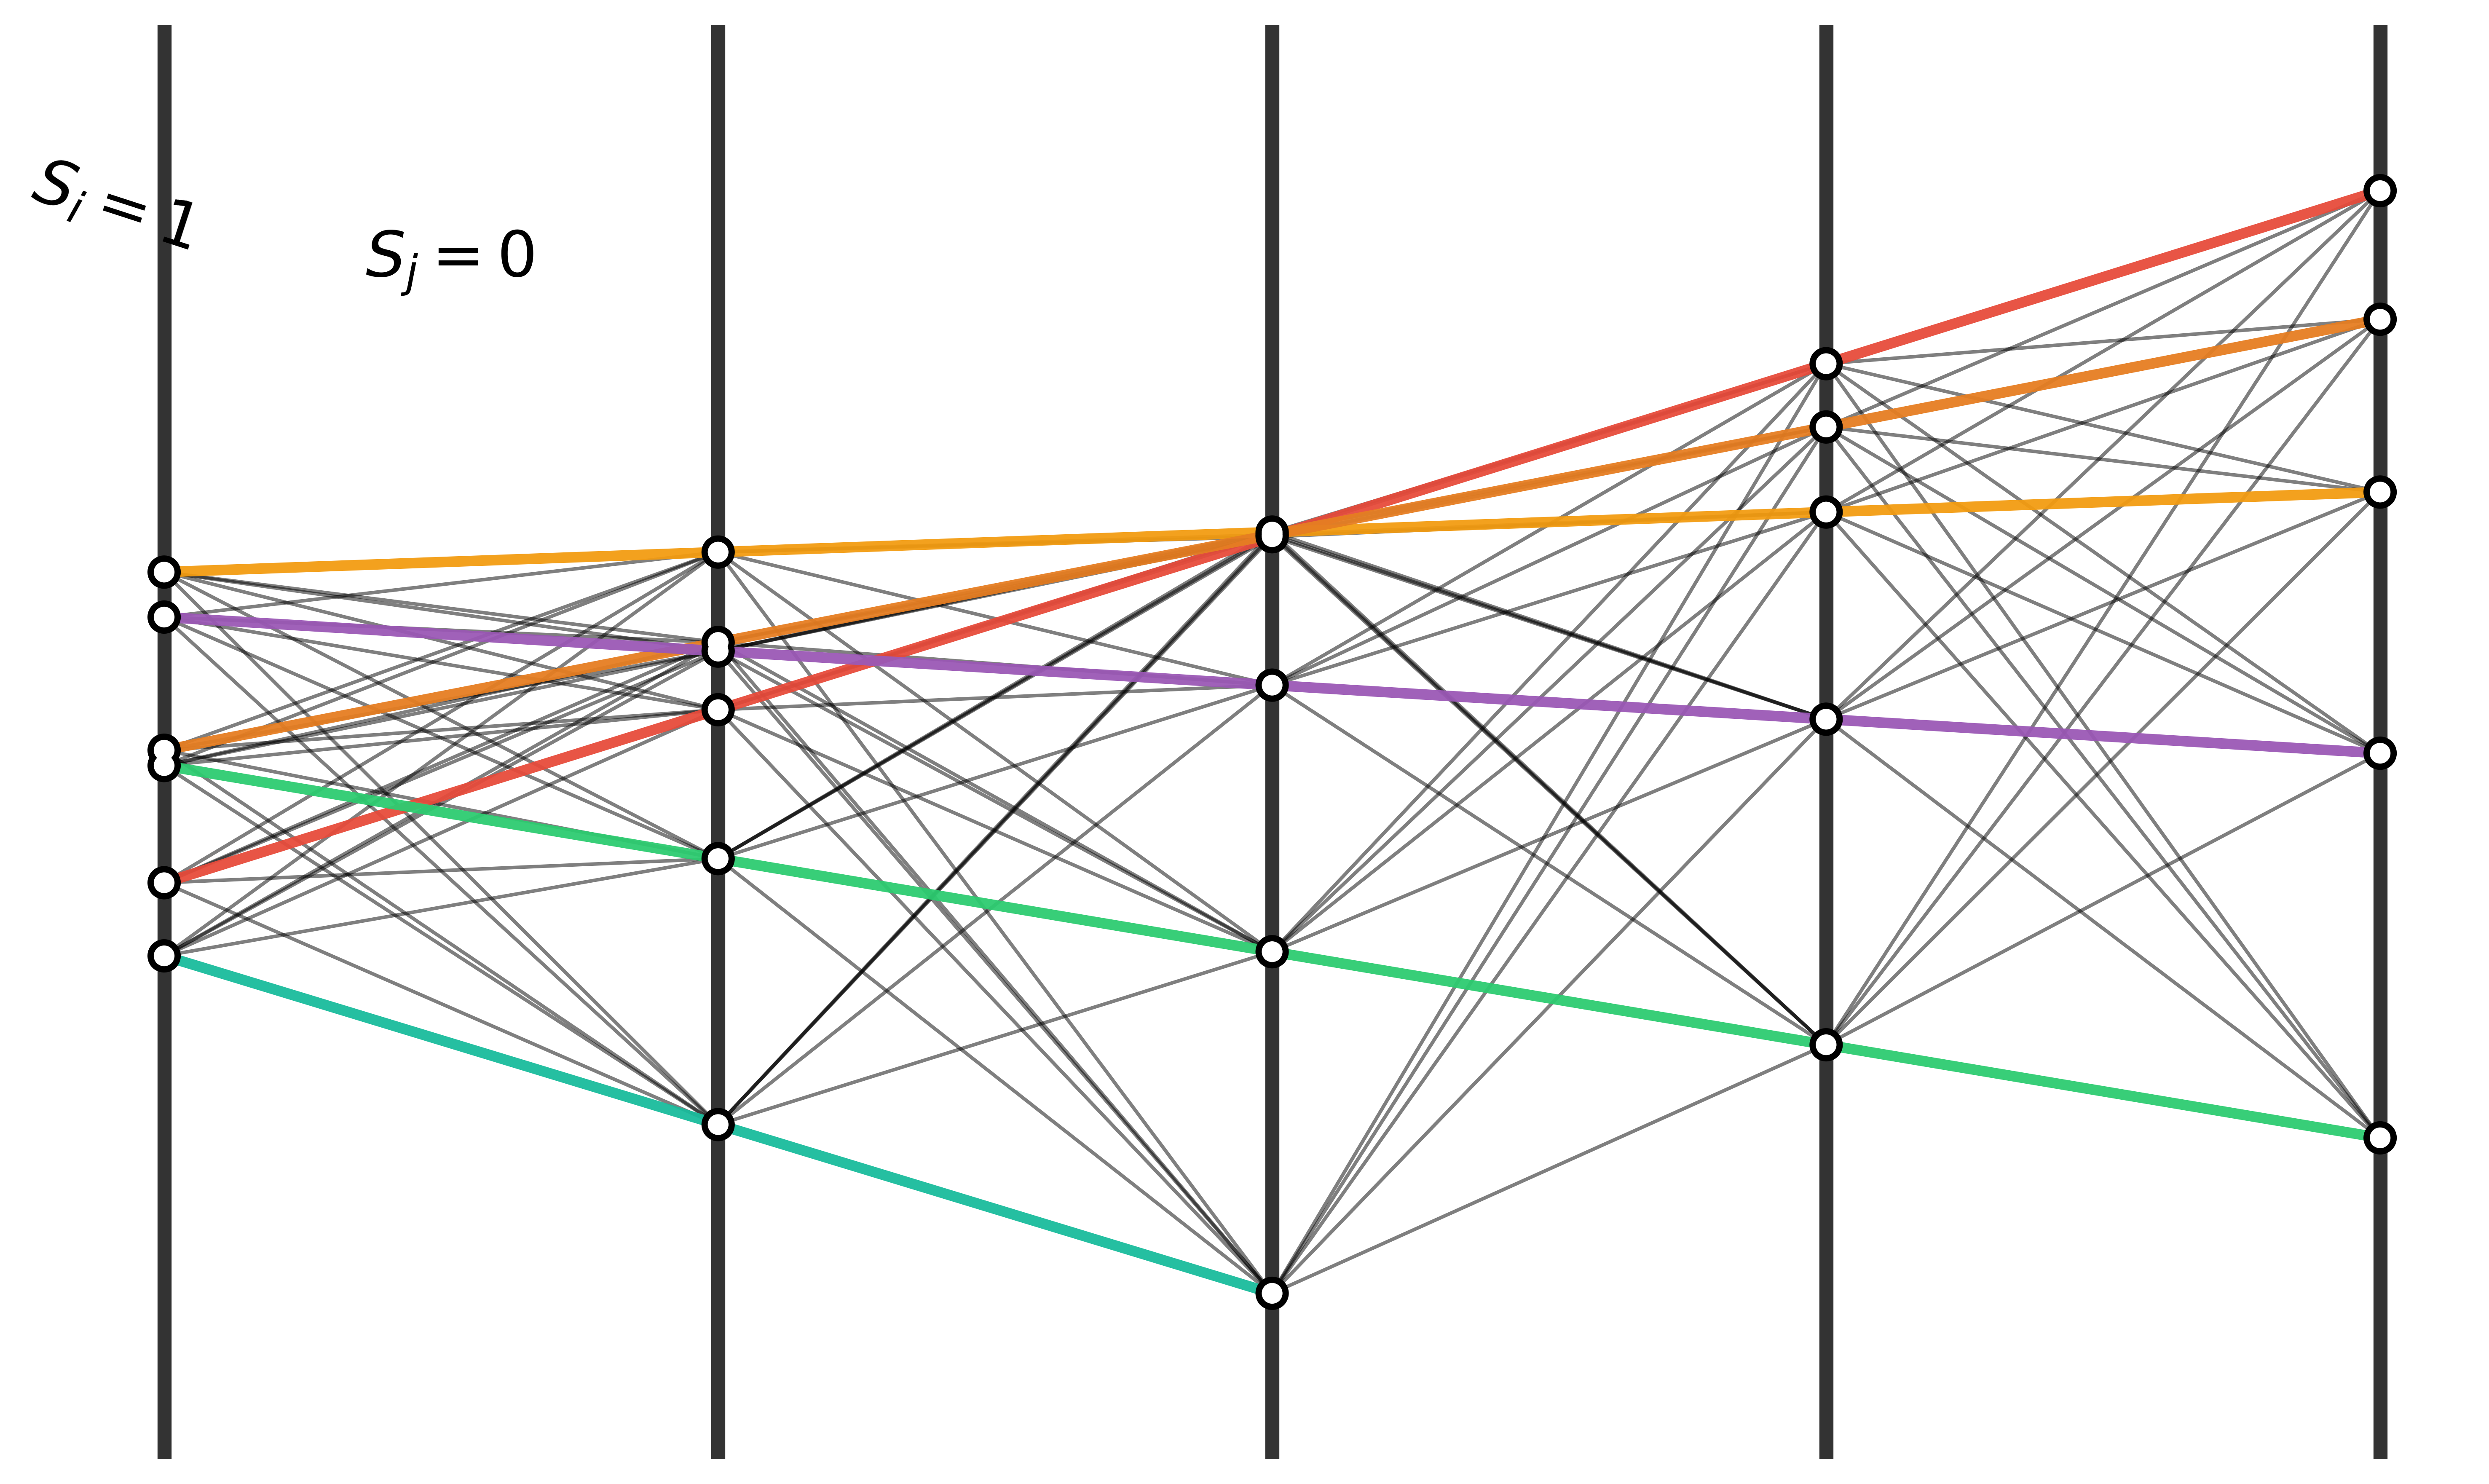

In [4]:
plot_event_paper_style(
    event_tracks, Detector,
    figsize=(10, 6),
    dpi=600,
    filename='paper_event_display',
    save_to_file=True,
    label_si_pos=(30, 12),
    label_sj_pos=(50, 10),
    show_pv=False,
)